# RNN Model

In [72]:
# ! wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
# ! sudo apt -y install p7zip-full
# ! wget http://ftp.br.debian.org/debian/pool/non-free/p/p7zip-rar/p7zip-rar_16.02-3_amd64.deb
# ! sudo dpkg -i p7zip-rar_16.02-3_amd64.deb
# ! 7z x UCF101.rar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Sca        1 file, 6932971618 bytes (6612 MiB)

Extracting archive: UCF101.rar
  0% 100 Ope            --
Path = UCF101.rar
Type = Rar
Physical Size = 6932971618
Solid = -
Blocks = 13422
Multivolume = -
Volumes = 1

 9    0% 87 - UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g15_c05.av                                                              0% 178 - UCF-101/ApplyLipstick/v_ApplyLipstick_g08_c02.a                                                            0% 258 - UCF-101/ApplyLipstick/v_ApplyLipstick_g25_c04.a                                                            1% 304 - UCF-101/Archery/v_Archery_g08_c05.a                                                1% 352 - UCF-101/Archery/v_Archery_g16_c05.a                                                2% 423 - U

In [1]:
! pip install av

import torch
from torch import nn
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader
import torchvision
from torchvision import io, models
from torchvision.datasets.folder import make_dataset
from torchvision.datasets.utils import list_dir

from sklearn.model_selection import train_test_split
import os
import re
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## PyTorch Dataset

In [26]:
class UCF101(torchvision.datasets.VisionDataset):
    def __init__(self, root, annotation, transform=None):
        super(UCF101, self).__init__(root)

        extensions = ('avi',)
        self.train = train

        classes = list(sorted(list_dir(root)))
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file=None)
        self.classes = classes

        video_list = [x[0] for x in self.samples]
        self.indices = [i for i in range(len(video_list)) if video_list[i] in annotation]
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        file_ = self.samples[self.indices[idx]][0]
        video, audio, info = io.read_video(file_, pts_unit='sec')
        label = self.samples[self.indices[idx]][1] - 1
        video = video.transpose(2, 3).transpose(1, 2)

        if self.transform is not None:
            video = self.transform(video)

        return video, audio, label

## Set up Training/Testing Datasets

In [27]:
file_list = {}
unique_list = []
# class_list = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']
class_list = ['ApplyLipstick', 'Archery']

f_re = re.compile('v_([A-Za-z]+)_g([0-9]+)_c([0-9]+).avi')
# Shuffle train/test dataset
for _, dirs, _ in os.walk('./UCF-101'):
    for dir in dirs:
        for _, _, files in os.walk(f'./UCF-101/{dir}'):
            for file in files:
                if dir in class_list:
                    m = f_re.match(file)
                    if m.group(1) not in file_list:
                        file_list[m.group(1)] = {}
                    if m.group(2) not in file_list[m.group(1)]:
                        file_list[m.group(1)][m.group(2)] = []
                    file_list[m.group(1)][m.group(2)].append(m.group(3))
                    unique_list.append(f'{m.group(1)}_{m.group(2)}')

unique_list = list(set(unique_list))
train, test = train_test_split(unique_list, random_state=42)

train_sublists = [[f'./UCF-101/{file.split("_")[0]}/v_{file.split("_")[0]}_g{file.split("_")[1]}_c{c}.avi' for c in file_list[file.split("_")[0]][file.split("_")[1]]] for file in train]
train_list = [item for sublist in train_sublists for item in sublist]

test_sublists = [[f'./UCF-101/{file.split("_")[0]}/v_{file.split("_")[0]}_g{file.split("_")[1]}_c{c}.avi' for c in file_list[file.split("_")[0]][file.split("_")[1]]] for file in test]
test_list = [item for sublist in test_sublists for item in sublist]

train_dataset = UCF101('./UCF-101', train_list)
val_dataset = UCF101('./UCF-101', test_list)

## Define RNN Model

In [4]:
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, num_classes, n_layers, drop_prob=0.2):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.conv = models.alexnet(pretrained=True)
        self.conv.classifier[-1] = nn.Identity()
        for param in self.conv.parameters():
            param.requires_grad = False
        self.gru = nn.GRU(4096, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, h=None):
        x = self.conv(x.squeeze(0))
        for frame in x:
            out, h = self.gru(frame.unsqueeze(0).unsqueeze(0), h)
        out = self.fc(out.squeeze(1))
        return out

## Define Evaluation Function

In [5]:
def evaluate(val_loader, model, criterion):
    correct_count = 0
    avg_loss = 0
    print('Evaluating...')
    loop = tqdm(total=len(val_loader), position=0, leave=True)
    for i, (video, audio, label) in enumerate(val_loader, 1):
        out = model(video.float().to(device))
        loss = criterion(out, label.to(device))
        avg_loss += loss.item()
        if torch.argmax(out) == label.to(device):
            correct_count += 1
        loop.update(1)
    loop.close()
    return avg_loss/len(val_loader), correct_count/len(val_loader)

## Define Training Function

In [37]:
def train(train_loader, val_loader, learn_rate, hidden_dim=256, EPOCHS=5, state_file=None):
    # Setting common hyperparameters
    input_dim = 240*320
    num_classes = len(class_list)
    n_layers = 2
    # Instantiating the model
    model = RNNModel(hidden_dim, num_classes, n_layers)
    # Load state_dict
    if state_file:
        if os.path.exists(state_file):
            model.load_state_dict(torch.load(state_file))
        else:
            print(f'WARNING: {state_file} does not exist. A new file will be created after first epoch.')
    model.to(device)
  
    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    train_losses = []
    avg_train_losses = []
    val_losses = []
    val_accs = []

    model.train()
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS+1):
        epoch_start = time.time()
        avg_loss = 0
        loop = tqdm(total=len(train_loader), position=0, leave=True)
        for i, (video, audio, label) in enumerate(train_loader, 1):
            model.zero_grad()
            out = model(video.float().to(device))
            loss = criterion(out, label.to(device))
            loss.backward()
            optimizer.step()
            loss_item = loss.item()
            avg_loss += loss_item

            train_losses.append(loss_item)
            loop.update(1)
            loop.set_description(f"Epoch {epoch}, Step: {i}/{len(train_loader)}, Loss: {loss_item}, Average Loss for Epoch: {avg_loss/i}")
        loop.close()

        avg_train_losses.append(avg_loss/len(train_loader))
        print()
        print(f"Epoch {epoch}/{EPOCHS} Done, Total Loss: {avg_train_losses[-1]}")
        print(f"Total Train Time Elapsed: {(time.time() - epoch_start):.2f} seconds")
        
        val_start = time.time()
        val_loss, accuracy = evaluate(val_loader, model, criterion)
        val_accs.append(accuracy)
        val_losses.append(val_loss)
        print()
        print(f"Total Val Time Elapsed: {(time.time() - val_start):.2f} seconds")
        print(f"Validator Loss: {val_loss}, Accuracy: {accuracy}")
        
        epoch_times.append(time.time()-epoch_start)

        # Save state_dict
        if state_file:
            torch.save(model.state_dict(), state_file)
  
    print(f"Total Training Time: {str(sum(epoch_times))} seconds")
    return model, train_losses, avg_train_losses, val_losses, val_accs

In [38]:
# Set up our data loaders
train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)
# Train our model
model, new_train_losses, new_avg_train_losses, new_val_losses, new_val_accs = train(train_loader, val_loader, .001, state_file='binary_model.pth', EPOCHS=25)
train_losses += new_train_losses
avg_train_losses += new_avg_train_losses
val_losses += new_val_losses
val_accs += new_val_accs

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Step: 196/196, Loss: 0.02611302025616169, Average Loss for Epoch: 0.3401291596421696: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]   
  2%|▏         | 1/63 [00:00<00:10,  6.04it/s]


Epoch 1/25 Done, Total Loss: 0.3401291596421696
Total Train Time Elapsed: 66.61 seconds
Evaluating...


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]



Total Val Time Elapsed: 18.00 seconds
Validator Loss: 0.42571316864008885, Accuracy: 0.8412698412698413


Epoch 2, Step: 196/196, Loss: 0.0003912875254172832, Average Loss for Epoch: 0.09459784119752264: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s] 
  2%|▏         | 1/63 [00:00<00:10,  6.07it/s]


Epoch 2/25 Done, Total Loss: 0.09459784119752264
Total Train Time Elapsed: 66.77 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.48it/s]



Total Val Time Elapsed: 18.09 seconds
Validator Loss: 0.5301851682489787, Accuracy: 0.8888888888888888


Epoch 3, Step: 196/196, Loss: 0.003724900772795081, Average Loss for Epoch: 0.12069033335817912: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]  
  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/25 Done, Total Loss: 0.12069033335817912
Total Train Time Elapsed: 66.63 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.47it/s]



Total Val Time Elapsed: 18.15 seconds
Validator Loss: 0.25966075016104795, Accuracy: 0.8888888888888888


Epoch 4, Step: 196/196, Loss: 0.1569015085697174, Average Loss for Epoch: 0.1048363796654132: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]     
  2%|▏         | 1/63 [00:00<00:10,  6.03it/s]


Epoch 4/25 Done, Total Loss: 0.1048363796654132
Total Train Time Elapsed: 66.63 seconds
Evaluating...


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]



Total Val Time Elapsed: 17.98 seconds
Validator Loss: 0.7887865539084905, Accuracy: 0.873015873015873


Epoch 5, Step: 196/196, Loss: 0.0028676362708210945, Average Loss for Epoch: 0.02660735823314544: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]  
  2%|▏         | 1/63 [00:00<00:10,  6.14it/s]


Epoch 5/25 Done, Total Loss: 0.02660735823314544
Total Train Time Elapsed: 66.70 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.46it/s]



Total Val Time Elapsed: 18.22 seconds
Validator Loss: 0.7124345232679179, Accuracy: 0.8888888888888888


Epoch 6, Step: 196/196, Loss: 0.0023582761641591787, Average Loss for Epoch: 0.0042120599394003914: 100%|██████████| 196/196 [01:06<00:00,  2.93it/s] 
  2%|▏         | 1/63 [00:00<00:10,  6.09it/s]


Epoch 6/25 Done, Total Loss: 0.0042120599394003914
Total Train Time Elapsed: 66.86 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.04 seconds
Validator Loss: 0.7242337276397776, Accuracy: 0.8888888888888888


Epoch 7, Step: 196/196, Loss: 0.0013842533808201551, Average Loss for Epoch: 0.001544333393089615: 100%|██████████| 196/196 [01:06<00:00,  2.93it/s]  
  2%|▏         | 1/63 [00:00<00:10,  5.83it/s]


Epoch 7/25 Done, Total Loss: 0.001544333393089615
Total Train Time Elapsed: 66.95 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.44it/s]



Total Val Time Elapsed: 18.31 seconds
Validator Loss: 0.8155736444191317, Accuracy: 0.8888888888888888


Epoch 8, Step: 196/196, Loss: 0.0022373187821358442, Average Loss for Epoch: 0.00034315500229518985: 100%|██████████| 196/196 [01:07<00:00,  2.91it/s] 
  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 8/25 Done, Total Loss: 0.00034315500229518985
Total Train Time Elapsed: 67.30 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.41it/s]



Total Val Time Elapsed: 18.49 seconds
Validator Loss: 0.8091817580155921, Accuracy: 0.8888888888888888


Epoch 9, Step: 196/196, Loss: 4.2199197196168825e-05, Average Loss for Epoch: 0.0002130289382565173: 100%|██████████| 196/196 [01:07<00:00,  2.91it/s] 
  2%|▏         | 1/63 [00:00<00:10,  5.81it/s]


Epoch 9/25 Done, Total Loss: 0.0002130289382565173
Total Train Time Elapsed: 67.47 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.40it/s]



Total Val Time Elapsed: 18.54 seconds
Validator Loss: 0.9274395360152091, Accuracy: 0.8888888888888888


Epoch 10, Step: 196/196, Loss: 2.074220174108632e-05, Average Loss for Epoch: 0.00020515543938203412: 100%|██████████| 196/196 [01:07<00:00,  2.91it/s] 
  2%|▏         | 1/63 [00:00<00:10,  5.75it/s]


Epoch 10/25 Done, Total Loss: 0.00020515543938203412
Total Train Time Elapsed: 67.40 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.08 seconds
Validator Loss: 0.9669987839735645, Accuracy: 0.8888888888888888


Epoch 11, Step: 196/196, Loss: 1.3112935448589269e-05, Average Loss for Epoch: 0.00012248779635298462: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]
  2%|▏         | 1/63 [00:00<00:10,  6.01it/s]


Epoch 11/25 Done, Total Loss: 0.00012248779635298462
Total Train Time Elapsed: 66.77 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.50it/s]



Total Val Time Elapsed: 18.02 seconds
Validator Loss: 1.0177356878024735, Accuracy: 0.8888888888888888


Epoch 12, Step: 196/196, Loss: 5.483612312673358e-06, Average Loss for Epoch: 9.113684309248091e-05: 100%|██████████| 196/196 [01:06<00:00,  2.93it/s]  
  2%|▏         | 1/63 [00:00<00:10,  5.94it/s]


Epoch 12/25 Done, Total Loss: 9.113684309248091e-05
Total Train Time Elapsed: 66.84 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.05 seconds
Validator Loss: 1.0162862630921456, Accuracy: 0.8888888888888888


Epoch 13, Step: 196/196, Loss: 1.1205610462639015e-05, Average Loss for Epoch: 8.632599492232527e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s] 
  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 13/25 Done, Total Loss: 8.632599492232527e-05
Total Train Time Elapsed: 66.70 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.45it/s]



Total Val Time Elapsed: 18.27 seconds
Validator Loss: 1.0468154461796544, Accuracy: 0.8888888888888888


Epoch 14, Step: 196/196, Loss: 8.737658936297521e-05, Average Loss for Epoch: 5.0244563209041506e-05: 100%|██████████| 196/196 [01:07<00:00,  2.92it/s] 
  2%|▏         | 1/63 [00:00<00:10,  5.65it/s]


Epoch 14/25 Done, Total Loss: 5.0244563209041506e-05
Total Train Time Elapsed: 67.09 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.41it/s]



Total Val Time Elapsed: 18.47 seconds
Validator Loss: 1.0547281460248816, Accuracy: 0.8888888888888888


Epoch 15, Step: 196/196, Loss: 9.65590606938349e-06, Average Loss for Epoch: 4.130950565628173e-05: 100%|██████████| 196/196 [01:07<00:00,  2.91it/s]   
  2%|▏         | 1/63 [00:00<00:10,  5.88it/s]


Epoch 15/25 Done, Total Loss: 4.130950565628173e-05
Total Train Time Elapsed: 67.28 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.42it/s]



Total Val Time Elapsed: 18.42 seconds
Validator Loss: 1.035049378635099, Accuracy: 0.8888888888888888


Epoch 16, Step: 196/196, Loss: 5.006777428206988e-06, Average Loss for Epoch: 3.93297363936134e-05: 100%|██████████| 196/196 [01:07<00:00,  2.90it/s]   
  2%|▏         | 1/63 [00:00<00:10,  6.10it/s]


Epoch 16/25 Done, Total Loss: 3.93297363936134e-05
Total Train Time Elapsed: 67.70 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.48it/s]



Total Val Time Elapsed: 18.08 seconds
Validator Loss: 1.027273080659139, Accuracy: 0.8888888888888888


Epoch 17, Step: 196/196, Loss: 4.970903682988137e-05, Average Loss for Epoch: 3.2460736173798256e-05: 100%|██████████| 196/196 [01:07<00:00,  2.92it/s] 
  2%|▏         | 1/63 [00:00<00:10,  6.03it/s]


Epoch 17/25 Done, Total Loss: 3.2460736173798256e-05
Total Train Time Elapsed: 67.11 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.05 seconds
Validator Loss: 1.1099700091518943, Accuracy: 0.8888888888888888


Epoch 18, Step: 196/196, Loss: 0.00011062010162277147, Average Loss for Epoch: 3.237970147020693e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s] 
  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 18/25 Done, Total Loss: 3.237970147020693e-05
Total Train Time Elapsed: 66.66 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.47it/s]



Total Val Time Elapsed: 18.17 seconds
Validator Loss: 1.0759938250628762, Accuracy: 0.8888888888888888


Epoch 19, Step: 196/196, Loss: 9.536738616588991e-07, Average Loss for Epoch: 2.553429465836286e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]  
  2%|▏         | 1/63 [00:00<00:10,  6.08it/s]


Epoch 19/25 Done, Total Loss: 2.553429465836286e-05
Total Train Time Elapsed: 66.72 seconds
Evaluating...


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]



Total Val Time Elapsed: 18.00 seconds
Validator Loss: 1.1022775977542503, Accuracy: 0.8888888888888888


Epoch 20, Step: 196/196, Loss: 6.6756979322235566e-06, Average Loss for Epoch: 2.2560349443247847e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]
  2%|▏         | 1/63 [00:00<00:10,  6.05it/s]


Epoch 20/25 Done, Total Loss: 2.2560349443247847e-05
Total Train Time Elapsed: 66.58 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.08 seconds
Validator Loss: 1.1298648278947834, Accuracy: 0.8888888888888888


Epoch 21, Step: 196/196, Loss: 1.6093124941107817e-05, Average Loss for Epoch: 2.277979316507215e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s] 
  2%|▏         | 1/63 [00:00<00:10,  6.07it/s]


Epoch 21/25 Done, Total Loss: 2.277979316507215e-05
Total Train Time Elapsed: 66.77 seconds
Evaluating...


100%|██████████| 63/63 [00:17<00:00,  3.52it/s]



Total Val Time Elapsed: 17.92 seconds
Validator Loss: 1.1558664939368275, Accuracy: 0.8888888888888888


Epoch 22, Step: 196/196, Loss: 5.483612312673358e-06, Average Loss for Epoch: 1.5130274317350401e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s] 
  2%|▏         | 1/63 [00:00<00:10,  6.04it/s]


Epoch 22/25 Done, Total Loss: 1.5130274317350401e-05
Total Train Time Elapsed: 66.70 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.04 seconds
Validator Loss: 1.1423810495397437, Accuracy: 0.8888888888888888


Epoch 23, Step: 196/196, Loss: 1.4662635294371285e-05, Average Loss for Epoch: 1.5467255056246264e-05: 100%|██████████| 196/196 [01:06<00:00,  2.95it/s]
  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 23/25 Done, Total Loss: 1.5467255056246264e-05
Total Train Time Elapsed: 66.53 seconds
Evaluating...


100%|██████████| 63/63 [00:17<00:00,  3.51it/s]



Total Val Time Elapsed: 17.97 seconds
Validator Loss: 1.1335874464320796, Accuracy: 0.8888888888888888


Epoch 24, Step: 196/196, Loss: 3.933898824470816e-06, Average Loss for Epoch: 1.192182862891922e-05: 100%|██████████| 196/196 [01:06<00:00,  2.95it/s]  
  2%|▏         | 1/63 [00:00<00:10,  6.05it/s]


Epoch 24/25 Done, Total Loss: 1.192182862891922e-05
Total Train Time Elapsed: 66.43 seconds
Evaluating...


100%|██████████| 63/63 [00:18<00:00,  3.49it/s]



Total Val Time Elapsed: 18.05 seconds
Validator Loss: 1.1461282473598138, Accuracy: 0.8888888888888888


Epoch 25, Step: 196/196, Loss: 2.7418097943154862e-06, Average Loss for Epoch: 1.2284732779984811e-05: 100%|██████████| 196/196 [01:06<00:00,  2.94it/s]
  2%|▏         | 1/63 [00:00<00:10,  6.08it/s]


Epoch 25/25 Done, Total Loss: 1.2284732779984811e-05
Total Train Time Elapsed: 66.58 seconds
Evaluating...


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]



Total Val Time Elapsed: 17.99 seconds
Validator Loss: 1.1968615847535904, Accuracy: 0.8888888888888888
Total Training Time: 2125.256676673889 seconds


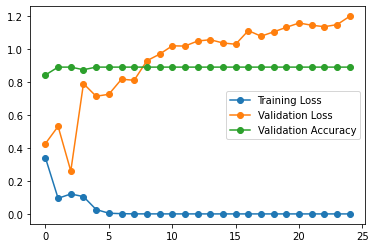

In [39]:
plt.plot(avg_train_losses, 'o-', label='Training Loss')
plt.plot(val_losses, 'o-', label='Validation Loss')
plt.plot(val_accs, 'o-', label='Validation Accuracy')
plt.legend()
plt.show()

In [29]:
train_losses = []
avg_train_losses = []
val_losses = []
val_accs = []